In [18]:
import torch
from torch import nn
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import copy
from copy import deepcopy
import sys
import os
import cv2
import pandas as pd
import numpy as np
import random
from pathlib import Path

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # dead kernel for matplotlib

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [20]:
metadata = pd.read_csv('../doby_meta.csv')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7064 entries, 0 to 7063
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject_id      7064 non-null   int64 
 1   study_id        7064 non-null   int64 
 2   dicom_id        7064 non-null   object
 3   DicomPath       7064 non-null   object
 4   edema_severity  7064 non-null   int64 
 5   normal          7064 non-null   int64 
 6   CHF             7064 non-null   bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 338.2+ KB


In [21]:
metadata = metadata[metadata['subject_id'] < 16000000]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4198 entries, 0 to 4197
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject_id      4198 non-null   int64 
 1   study_id        4198 non-null   int64 
 2   dicom_id        4198 non-null   object
 3   DicomPath       4198 non-null   object
 4   edema_severity  4198 non-null   int64 
 5   normal          4198 non-null   int64 
 6   CHF             4198 non-null   bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 233.7+ KB


In [22]:
SEG_BASE_PATH = '../chest-x-ray-dataset-with-lung-segmentation-1.0.0/chest-x-ray-dataset-with-lung-segmentation-1.0.0'
ORIG_BASE_PATH = '../physionet.org/files/mimic-cxr-jpg/2.0.0'

In [23]:
class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, x_seg, x_orig):
        return x_seg, x_orig.resize((self.size, self.size))

class MixImage(object):
    def __call__(self, fore, back):
        back.paste(fore, (0, 0), fore)
        return back

TRANSFORMS = transforms.Compose([
    transforms.ToTensor()
])

In [24]:
class Dataset(Dataset):
    def __init__(self, metadata, seg_base_path, orig_base_path, transform=None):
        self.metadata = metadata
        self.seg_base_path = Path(seg_base_path)
        self.orig_base_path = Path(orig_base_path)
        self.transform = transform

    def __getitem__(self, idx):
        x_path = self.metadata.loc[idx, 'DicomPath']
        x_seg_mask_path = self.seg_base_path / Path(x_path[:-4] + '-mask.jpg')
        x_seg_path = self.seg_base_path / Path(x_path)
        x_orig_path = self.orig_base_path / Path(x_path)

        x_seg = cv2.imread(str(x_seg_path), cv2.IMREAD_GRAYSCALE)
        x_seg = cv2.resize(x_seg, dsize=(64, 64), interpolation=cv2.INTER_AREA)
        x_seg_mask = cv2.imread(str(x_seg_mask_path), cv2.IMREAD_GRAYSCALE)
        x_seg_mask = cv2.resize(x_seg_mask, dsize=(64, 64), interpolation=cv2.INTER_AREA)
        x_orig = cv2.imread(str(x_orig_path), cv2.IMREAD_GRAYSCALE)
        x_orig = cv2.resize(x_orig, dsize=(64, 64), interpolation=cv2.INTER_AREA)

        # 노이즈 제거
        seg_mask1 = np.where(x_seg_mask > 128, 1, 0) # 128 threshold
        # 반전 마스크 및 노이즈 제거
        seg_mask2 = np.where(x_seg_mask < 128, 1, 0) # 128 threshold

        x_lung_seg = x_orig*seg_mask1

        # Gaussian Blur 적용
        x_orig_blur = Image.fromarray(x_orig).convert('L')
        x_orig_blur = x_orig_blur.filter(ImageFilter.GaussianBlur(1))
        x_orig_blur = np.array(x_orig_blur)

        # Lung Segmentation 제외 제거
        x_background = x_orig_blur*seg_mask2 # lung segmentation 제외 비우기
        seg_mask3 = np.where(x_seg_mask > 128, 255, 0).astype(np.uint8) # 타입 CV_8U 오류 방지

        # Background에 Lung Segmentation 붙이기
        x_merge = cv2.copyTo(x_lung_seg, seg_mask3, x_background)
        x_merge = Image.fromarray(x_merge).convert('L')
        
        # Histogram Equalization
        x_merge = ImageOps.equalize(x_merge)
        
        y = self.metadata.loc[idx, 'normal']

        if self.transform:
            x = self.transform(x_merge)

        return x, y

    def __len__(self):
        return self.metadata['normal'].count()

In [25]:
ds = Dataset(metadata, SEG_BASE_PATH, ORIG_BASE_PATH, transform=TRANSFORMS)

In [26]:
ds_size = len(ds)
train_size = int(ds_size * 0.8)
test_size = ds_size - train_size
train_ds, test_ds = random_split(ds, [train_size, test_size], generator=torch.manual_seed(42))

In [27]:
print(len(train_ds), len(test_ds))

3358 840


In [28]:
test_dl = DataLoader(test_ds, batch_size=8, shuffle=True)

In [29]:
class CusVgg16(nn.Module):
    def __init__(self):
        super(CusVgg16, self).__init__()
        self.vgg = models.vgg16()
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.vgg.classifier[6] = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.vgg(x)
        x = self.sigmoid(x)

        return x

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

PATH = '../classification2/parameters/merge_best_acc_model_state.pt'
model = CusVgg16()
model.load_state_dict(torch.load(PATH))
model.to(device)

PATH2 = '../classification2/parameters/merge_best_f1_model_state.pt'
model2 = CusVgg16()
model2.load_state_dict(torch.load(PATH2))
model2.to(device)

CusVgg16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [31]:
weights = (metadata['normal'] == 1).sum() / (metadata['normal'] == 0).sum()
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weights])).to(device)

In [32]:
def getMetric(TP, FP, TN, FN):
    # base case: divide by zero
    TP = 0.1 if TP == 0 else TP
    FP = 0.1 if FP == 0 else FP
    TN = 0.1 if TN == 0 else TN
    FN = 0.1 if FN == 0 else FN
    
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*precision*recall/(precision+recall)
    return sensitivity, specificity, f1_score

In [33]:
def test(model, data_loader):
    model.eval()
    test_acc = 0
    test_loss = 0
    n_data = 0
    TP, FP, TN, FN = 0, 0, 0, 0
    pre = []
    tar = []
    
    with torch.no_grad():
        for batch, target in data_loader:
            batch, target = batch.to(device), target.to(device)

            output = model(batch)
            target = target.unsqueeze(dim=-1).float()
            temp_pre = output.cpu().detach().numpy()
            pre.append(temp_pre)
            temp_tar = target.cpu().detach().numpy()
            tar.append(temp_tar)

            loss = loss_fn(output, target)
            test_loss += loss.item()

            predicted = (output >= torch.FloatTensor([0.5]).to(device)).type(torch.float32)
            correct = (predicted == target).sum().item()
            test_acc += correct

            TP += ((predicted == target) & (target == 1)).sum().item()
            FP += ((predicted != target) & (target == 0)).sum().item()
            TN += ((predicted == target) & (target == 0)).sum().item()
            FN += ((predicted != target) & (target == 1)).sum().item()
            
            n_data += len(batch)
            print(f'\rTest set: [{100*n_data/len(data_loader.dataset):.2f}%]', end='')
    
    test_acc = 100 * test_acc / len(data_loader.dataset)
    test_loss = test_loss / len(data_loader)
    
    print(f'\rTest set: Accuracy: {test_acc:.2f}%  Loss: {test_loss:.4f}')

    return test_acc, test_loss, TP, FP, TN, FN, pre, tar

In [34]:
acc, loss, tp, fp, tn, fn, pre, tar = test(model, test_dl)
sensitivity, specificity, f1_score = getMetric(tp, fp, tn, fn)
print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')
print(f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, F1-Score: {f1_score:.4f}')

Test set: Accuracy: 65.24%  Loss: 0.7433
TP: 362, FP: 153, TN: 186, FN: 139
Sensitivity: 0.7226, Specificity: 0.5487, F1-Score: 0.7126


AUC: 0.6939


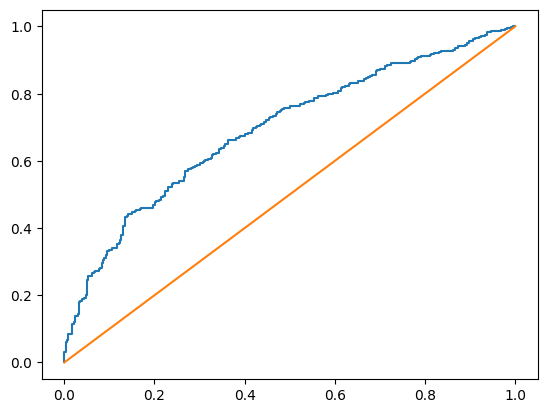

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

pre = np.array(pre).flatten()
tar = np.array(tar).flatten()
fpr, tpr, thresholds = roc_curve(tar, pre)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
print(f'AUC: {roc_auc_score(tar, pre):.4f}')

In [36]:
np.save('./target_and_predict/merge_acc_tar', tar)
np.save('./target_and_predict/merge_acc_pre', pre)

In [37]:
acc, loss, tp, fp, tn, fn, pre, tar = test(model2, test_dl)
sensitivity, specificity, f1_score = getMetric(tp, fp, tn, fn)
print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')
print(f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, F1-Score: {f1_score:.4f}')

Test set: Accuracy: 63.45%  Loss: 0.7635
TP: 430, FP: 236, TN: 103, FN: 71
Sensitivity: 0.8583, Specificity: 0.3038, F1-Score: 0.7369


AUC: 0.6570


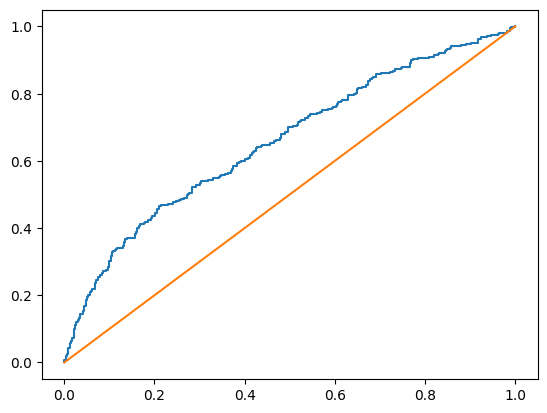

In [38]:
pre = np.array(pre).flatten()
tar = np.array(tar).flatten()
fpr, tpr, thresholds = roc_curve(tar, pre)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
print(f'AUC: {roc_auc_score(tar, pre):.4f}')

In [39]:
np.save('./target_and_predict/merge_f1_tar', tar)
np.save('./target_and_predict/merge_f1_pre', pre)